# ***MAIN FUNCTIONALITY***

In [1]:
from meteo.Site import Site
from solar.SolarPVArray import SolarPVArray
from solar.SolarPVModel import SolarPVModel

from misc.log_config import configure_logging
from misc.util import load_pv_model

configure_logging()

# Set up site location and get TMY data
name = ""
address = "York St, Belfast, BT15 1ED"
client = "Ulster University"

site = Site(name=name, 
            address=address, 
            client=client, 
            latitude=54.60452, 
            longitude=-5.92860, 
            size=100)

# Set up PV arrays
pv_kwp = 1
surface_pitch = 35
surface_azimuth = -90
lifespan = 25
pv_eol_derating = 0.88
pv_cost = 1250
efficiency = 0.21
temp_coeff = -0.0035
transmission_absorption = 0.9
refraction_index = 0.1

array_1 = SolarPVArray(pv_kwp, surface_pitch, surface_azimuth, lifespan, pv_eol_derating,
                       pv_cost, efficiency, temp_coeff, transmission_absorption, refraction_index)

array_2 = SolarPVArray(1, 35, -45, cost_per_kWp=pv_cost)
array_3 = SolarPVArray(1, 35, 0, 25, 0.88)
array_4 = SolarPVArray(1, 35, 45)
array_5 = SolarPVArray(1, 35, 90)

# Arrange all arrays into list for modelling
arrays = [array_1, array_2, array_3, array_4, array_5]

# Run SolarPV model
pv_model = SolarPVModel(site, arrays)

# Save model as .wmm file
pv_model.save_model()

# Load .wwm model from file
pv_model = load_pv_model()


2024-02-18 02:26:04,261 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-18 02:26:07,605 - INFO - HTTP Request: GET https://re.jrc.ec.europa.eu/api/tmy?lat=54.60452&lon=-5.9286&startyear=2005&endyear=2015&outputformat=json "HTTP/1.1 200 OK"
2024-02-18 02:26:08,261 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-18 02:26:08,262 - INFO - *******************
2024-02-18 02:26:08,262 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: -90deg, Lifespan: 25yrs
2024-02-18 02:26:08,263 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: -45deg, Lifespan: 25yrs
2024-02-18 02:26:08,264 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: 0deg, Lifespan: 25yrs
2024-02-18 02:26:08,264 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: 45deg, Lifespan: 25yrs
2024-02-18 02:26:08,264 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: 90deg, Lifespan: 25yrs
2024-02-18 02:26:08,2

In [2]:
pv_model.summary_grouped.quarterly

,PV_Gen_kWh_Total,E_POA_kWm2_Total,Panel_POA_kWm2_Total,IAM_Loss_kWm2_Total,PV_Thermal_Loss_kWh_Total,E_Beam_kWm2_Total,E_Diffuse_kWm2_Total,E_Ground_kWm2_Total,ET_HRad_kWm2_Total,Cell_Temp_C_Avg,T2m
Month_of_Year,,,,,,,,,,,
1,515.188,533.242,515.549,17.693,0.003,222.882,301.800,8.561,1581.657,5.258,4.267
2,1954.088,2009.719,1968.598,41.121,10.970,904.922,1067.430,37.367,4575.391,14.143,10.351
3,1680.592,1734.229,1698.280,35.949,12.700,716.318,986.169,31.741,4068.642,16.929,13.686
4,480.432,503.920,482.537,21.384,0.170,264.033,232.222,7.666,1127.206,8.120,7.208


In [3]:
import plotly.express as px
import seaborn as sns

px.bar(pv_model.summary_grouped.daily.PV_Gen_kWh_Total)

# ***Performance Test***

In [4]:
# Performance Testing
# import pstats
# import cProfile
# from meteo.Site import Site
# from solar.SolarPVArray import SolarPVArray
# from solar.SolarPVModel import SolarPVModel
# from misc.log_config import configure_logging
# from misc.util import load_pv_model
# configure_logging()
# array_1 = SolarPVArray(1, 35, 0, 25, 0.88)
# cProfile.run("SolarPVModel(site=Site(latitude=54.60452, longitude=-5.92860, size=100), arrays=[array_1])", 'performance_test.prof')
# p = pstats.Stats('performance_test.prof')
# p.sort_stats('tottime').print_stats()
# p.sort_stats('cumtime').print_stats()

# ***Example Running Model with variable inputs***

In [5]:
# %%timeit

from meteo.Site import Site
from solar.SolarPVArray import SolarPVArray
from solar.SolarPVModel import SolarPVModel

from misc.log_config import configure_logging

configure_logging()

# Set up site and obtain TMY data
site = Site(name="Test Site", address = "123 Test Street", client = "Big Gerry", 
            latitude=54.60452, longitude=-5.92860, tmz_hrs_east = 0)

2024-02-18 02:26:09,621 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-18 02:26:09,622 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-18 02:26:09,623 - INFO - *******************


In [6]:
# %%timeit

pv_kwp = 1
surface_pitch = 35
surface_azimuth = -90
lifespan = 25
pv_eol_derating = 0.88

# Set up PV arrays
array_1 = SolarPVArray(pv_kwp, surface_pitch, surface_azimuth, lifespan, pv_eol_derating)
array_2 = SolarPVArray(1, 35, -45, 25, 0.88)
array_3 = SolarPVArray(1, 35, 0, 25, 0.88)
array_4 = SolarPVArray(1, 35, 45, 25, 0.88)
array_5 = SolarPVArray(1, 35, 90, 25, 0.88)
arrays = [array_1, array_2, array_3, array_4, array_5]

# Set up and run model
pv_model = SolarPVModel(site=site, arrays=arrays)

2024-02-18 02:26:09,633 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: -90deg, Lifespan: 25yrs
2024-02-18 02:26:09,634 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: -45deg, Lifespan: 25yrs
2024-02-18 02:26:09,635 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: 0deg, Lifespan: 25yrs
2024-02-18 02:26:09,636 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: 45deg, Lifespan: 25yrs
2024-02-18 02:26:09,636 - INFO - Solar PV array created: Size: 1kW, Pitch: 35deg, Azimuth: 90deg, Lifespan: 25yrs
2024-02-18 02:26:09,637 - INFO - *******************
2024-02-18 02:26:09,638 - INFO - Starting Solar PV model simulations.
2024-02-18 02:26:09,638 - INFO - *******************
2024-02-18 02:26:09,638 - INFO - Simulating model - PV Size: 1kWp, Pitch: 35 degrees, Azimuth -90 degrees WoS
2024-02-18 02:26:09,646 - INFO - Simulating model - PV Size: 1kWp, Pitch: 35 degrees, Azimuth -45 degrees WoS
2024-02-18 02:26:09,653 - INFO - 

In [7]:
px.bar(pv_model.summary_grouped.monthly[["E_Beam_kWm2_Total", "E_Diffuse_kWm2_Total", "E_Ground_kWm2_Total"]])

In [8]:
px.line(pv_model.summary_grouped.monthly[["ET_HRad_kWm2_Total", "E_POA_kWm2_Total", "Panel_POA_kWm2_Total"]])

In [9]:
pv_model.summary

PV_Gen_kWh_Annual               4630.299
PV_Gen_kWh_Lifetime           108534.210
E_POA_kWm2_Annual               4781.110
Panel_POA_kWm2_Annual           4664.964
IAM_Loss_kWm2_Annual             116.146
PV_Thermal_Loss_kWh_Annual        23.843
E_Beam_kWm2_Annual              2108.155
E_Diffuse_kWm2_Annual           2587.621
E_Ground_kWm2_Annual              85.334
ET_HRad_kWm2_Annual            11352.896
Cell_Temp_C_Avg                   11.136
T2m_Avg                            8.899
dtype: float64

In [10]:
pv_model.combined_model

,E_Beam_kWm2_Total,E_Diffuse_kWm2_Total,E_Ground_kWm2_Total,E_POA_kWm2_Total,Panel_POA_kWm2_Total,ET_HRad_kWm2_Total,Cell_Temp_C_Avg,PV_Gen_kWh_Total,PV_Thermal_Loss_kWh_Total,IAM_Loss_kWm2_Total,Declination_Angle,Solar_Time,Hour_Angle,T2m,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.0,0.0,0.0,0.0,0.0,0.0,3.07,0.0,0.0,0.0,-23.011637,0.056353,-179.154706,3.07,0,1,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0,0.0,-23.011637,1.056353,-164.154706,2.63,1,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,2.18,0.0,0.0,0.0,-23.011637,2.056353,-149.154706,2.18,2,1,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.73,0.0,0.0,0.0,-23.011637,3.056353,-134.154706,1.73,3,1,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.28,0.0,0.0,0.0,-23.011637,4.056353,-119.154706,1.28,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,0.0,0.0,0.0,0.0,0.0,5.31,0.0,0.0,0.0,-23.085911,19.063871,105.958063,5.31,19,365,52,12
8756,0.0,0.0,0.0,0.0,0.0,0.0,4.86,0.0,0.0,0.0,-23.085911,20.063871,120.958063,4.86,20,365,52,12
8757,0.0,0.0,0.0,0.0,0.0,0.0,4.41,0.0,0.0,0.0,-23.085911,21.063871,135.958063,4.41,21,365,52,12
8758,0.0,0.0,0.0,0.0,0.0,0.0,3.97,0.0,0.0,0.0,-23.085911,22.063871,150.958063,3.97,22,365,52,12


# ***Visualisation***

In [11]:
import plotly.express as px
import seaborn as sns

In [12]:
pv_model.array_model(1).head()

,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year,T2m,Declination_Angle,Solar_Time,Hour_Angle,AOI,Zenith_Angle,...,E_Diffuse_kWm2,E_Ground_kWm2,E_POA_kWm2,Panel_POA_kWm2,IAM_Loss_kWm2,ET_HRad_kWm2,PV_Derated_Eff,Cell_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh
0,0,1,1,1,3.07,-23.011637,0.056353,-179.154706,154.774096,148.400772,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3.07,0.0,0.0
1,1,1,1,1,2.63,-23.011637,1.056353,-164.154706,141.273177,146.256695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.63,0.0,0.0
2,2,1,1,1,2.18,-23.011637,2.056353,-149.154706,127.879768,140.930673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.18,0.0,0.0
3,3,1,1,1,1.73,-23.011637,3.056353,-134.154706,114.680808,133.633323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.73,0.0,0.0
4,4,1,1,1,1.28,-23.011637,4.056353,-119.154706,101.782295,125.337294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.28,0.0,0.0


In [13]:
print(f"PV Gen: {round(pv_model.all_models.PV_Gen_kWh_Array_1.sum(), 3)}kWh")
print(f"E POA: {round(pv_model.all_models.E_POA_kWm2_Array_1.sum(), 3)}kWhm2")

PV Gen: 841.858kWh
E POA: 869.123kWhm2


In [14]:
px.bar(pv_model.summary_grouped.hourly[["PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [15]:
px.bar(pv_model.summary_grouped.monthly[["PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [16]:
px.bar(pv_model.summary_grouped.weekly[["PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [17]:
px.bar(pv_model.summary_grouped.daily[["PV_Gen_kWh_Total", "IAM_Loss_kWm2_Total", "PV_Thermal_Loss_kWh_Total"]])

In [18]:
px.line(pv_model.models[0]["model_result"][["Cell_Temp_C", "T2m"]])


<Axes: >

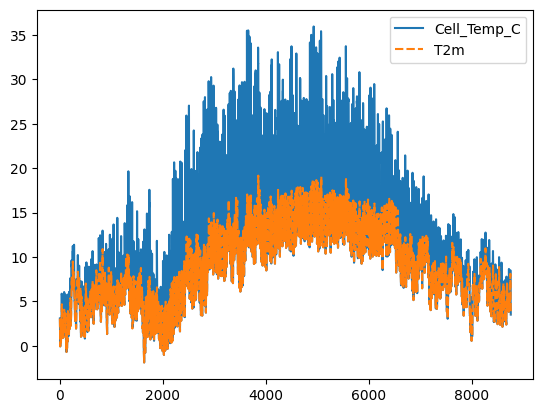

In [19]:
sns.lineplot(pv_model.models[0]["model_result"][["Cell_Temp_C", "T2m"]])

In [20]:
px.line(pv_model.models[0]["model_result"][["ET_HRad_kWm2", "E_POA_kWm2"]])

<Axes: >

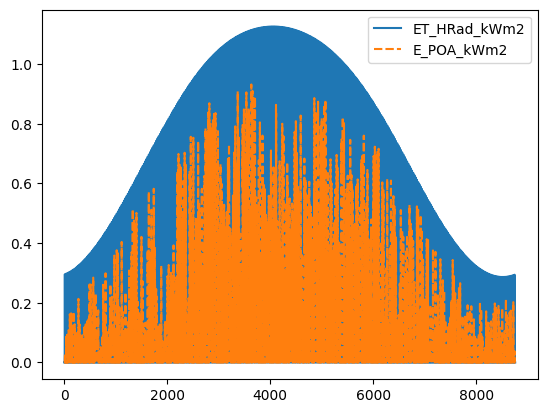

In [21]:
sns.lineplot(pv_model.models[0]["model_result"][["ET_HRad_kWm2", "E_POA_kWm2"]])

# ***Mass Model Testing***

In [22]:
# %%timeit
import random

# Assuming the Site, SolarPVArray, and SolarPVModel classes are defined elsewhere
site = Site(name="Test Site", address="123 Test Street", client="Big Gerry", 
            latitude=54.60452, longitude=-5.92860, tmz_hrs_east=0)

surface_pitch = 35
azimuth_list = [90, 45, 0, -45, -90]
pv_eol = 0.88
cost = 1250
lifespan = 25
eff = 0.21
temp_coeff = -0.0048
t_ab = 0.9

max_pv = 7.5
min_pv = 2.5
pv_step_size = 0.25
pv_list = []
pv_models = {}

for i in range(int((max_pv - min_pv) / pv_step_size)):
    pv_list.append(min_pv + (i * pv_step_size))

for pv_size in pv_list:
    pv_kwp = pv_size

    array_1 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[0], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)
    array_2 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[1], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)
    array_3 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[2], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)
    array_4 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[3], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)
    array_5 = SolarPVArray(pv_kwp, surface_pitch, azimuth_list[4], lifespan, pv_eol, cost, eff, temp_coeff, t_ab)

    # Initialize and run the SolarPVModel with all arrays
    arrays = [array_1, array_2, array_3, array_4, array_5]
    pv_model = SolarPVModel(site=site, arrays=arrays)

    pv_models[pv_size] = pv_model  # Store the model with pv_size as the key

Total_gen = 0

for model in pv_models.values():
    Total_gen += model.summary.PV_Gen_kWh_Annual

print("")
print("***************************************************")
print(f"{round(Total_gen / 1000, 3)} MWh from {len(pv_list)} models simulating {len(pv_list) * 5} PV arrays in total.")


2024-02-18 02:26:10,836 - INFO - Fetching TMY data for latitude: 54.60452, longitude: -5.9286
2024-02-18 02:26:10,836 - INFO - TMY data obtained for: 54.60452, longitude: -5.9286
2024-02-18 02:26:10,837 - INFO - *******************
2024-02-18 02:26:10,838 - INFO - Solar PV array created: Size: 2.5kW, Pitch: 35deg, Azimuth: 90deg, Lifespan: 25yrs
2024-02-18 02:26:10,838 - INFO - Solar PV array created: Size: 2.5kW, Pitch: 35deg, Azimuth: 45deg, Lifespan: 25yrs
2024-02-18 02:26:10,838 - INFO - Solar PV array created: Size: 2.5kW, Pitch: 35deg, Azimuth: 0deg, Lifespan: 25yrs
2024-02-18 02:26:10,839 - INFO - Solar PV array created: Size: 2.5kW, Pitch: 35deg, Azimuth: -45deg, Lifespan: 25yrs
2024-02-18 02:26:10,840 - INFO - Solar PV array created: Size: 2.5kW, Pitch: 35deg, Azimuth: -90deg, Lifespan: 25yrs
2024-02-18 02:26:10,840 - INFO - *******************
2024-02-18 02:26:10,841 - INFO - Starting Solar PV model simulations.
2024-02-18 02:26:10,842 - INFO - *******************
2024-02-18 


***************************************************
450.57 MWh from 20 models simulating 100 PV arrays in total.


In [23]:
pv_models.get(2.5).models[0]["model_result"]

,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year,T2m,Declination_Angle,Solar_Time,Hour_Angle,AOI,Zenith_Angle,...,E_Diffuse_kWm2,E_Ground_kWm2,E_POA_kWm2,Panel_POA_kWm2,IAM_Loss_kWm2,ET_HRad_kWm2,PV_Derated_Eff,Cell_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh
0,0,1,1,1,3.07,-23.011637,0.056353,-179.154706,134.868988,148.400772,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3.07,0.0,0.0
1,1,1,1,1,2.63,-23.011637,1.056353,-164.154706,145.619004,146.256695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.63,0.0,0.0
2,2,1,1,1,2.18,-23.011637,2.056353,-149.154706,155.047781,140.930673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.18,0.0,0.0
3,3,1,1,1,1.73,-23.011637,3.056353,-134.154706,160.738141,133.633323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.73,0.0,0.0
4,4,1,1,1,1.28,-23.011637,4.056353,-119.154706,159.201881,125.337294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.28,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19,365,52,12,5.31,-23.085911,19.063871,105.958063,82.791716,117.783501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995203,5.31,0.0,0.0
8756,20,365,52,12,4.86,-23.085911,20.063871,120.958063,91.941559,126.422350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995202,4.86,0.0,0.0
8757,21,365,52,12,4.41,-23.085911,21.063871,135.958063,102.050368,134.640378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995202,4.41,0.0,0.0
8758,22,365,52,12,3.97,-23.085911,22.063871,150.958063,112.785289,141.764593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995201,3.97,0.0,0.0


In [24]:
# Access values from dictionary
pv_models.get(2.5).summary_grouped.daily.PV_Gen_kWh_Total.sum()

11553.074

2024-02-18 02:26:12,685 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-18 02:26:12,689 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Month_of_Year'>

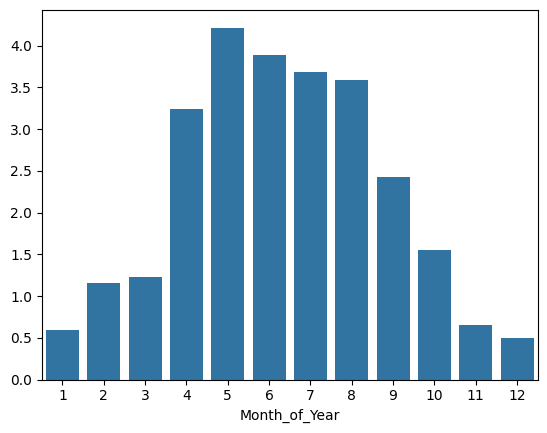

In [25]:
sns.barplot(pv_models.get(2.5).summary_grouped.monthly.Cell_Temp_C_Avg - pv_models.get(2.5).summary_grouped.monthly.T2m)

2024-02-18 02:26:12,828 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-18 02:26:12,834 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Week_of_Year', ylabel='PV_Gen_kWh_Total'>

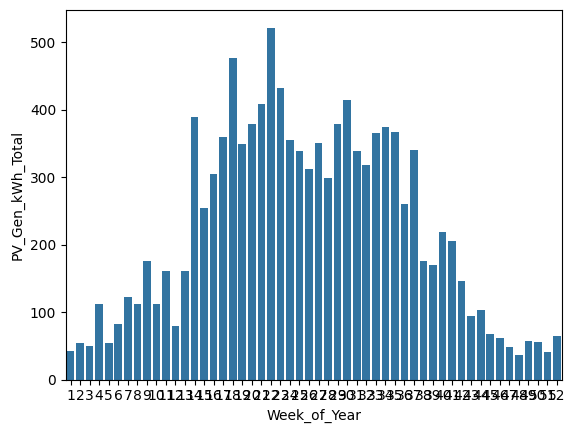

In [26]:
sns.barplot(pv_models.get(2.5).summary_grouped.weekly.PV_Gen_kWh_Total)

2024-02-18 02:26:13,218 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-18 02:26:13,224 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Day_of_Year', ylabel='PV_Gen_kWh_Total'>

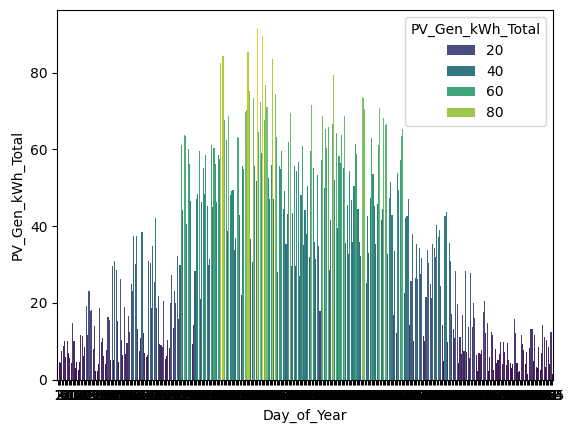

In [27]:
sns.barplot(data=pv_models.get(2.5).summary_grouped.daily, x="Day_of_Year", y="PV_Gen_kWh_Total", 
            hue="PV_Gen_kWh_Total", palette="viridis")

In [28]:
for pv_size in pv_list:
    print(f"{round(pv_models.get(pv_size).summary_grouped.daily.PV_Gen_kWh_Total.sum() / 1000, 3)} MWh/yr")

11.553 MWh/yr
12.708 MWh/yr
13.864 MWh/yr
15.019 MWh/yr
16.174 MWh/yr
17.33 MWh/yr
18.485 MWh/yr
19.64 MWh/yr
20.796 MWh/yr
21.951 MWh/yr
23.106 MWh/yr
24.261 MWh/yr
25.417 MWh/yr
26.572 MWh/yr
27.727 MWh/yr
28.883 MWh/yr
30.038 MWh/yr
31.193 MWh/yr
32.349 MWh/yr
33.504 MWh/yr


# ***VISUAL TESTING***

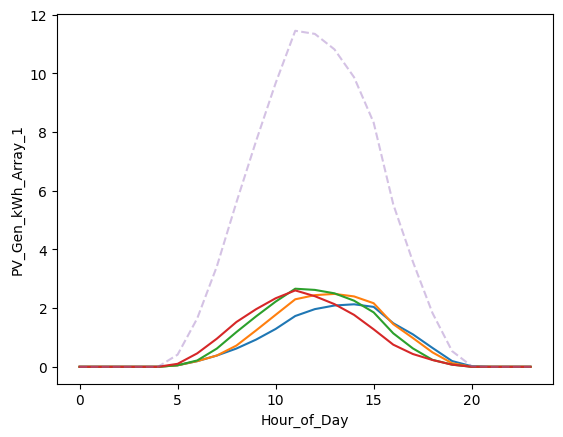

In [29]:
variables = ['E_Beam_Wm2', 'E_Diffuse_Wm2', 'E_Ground_Wm2', 'E_POA_Wm2', 'ET_HRad_Wm2', 
            'Cell_Temp_C', 'PV_Gen_kWh', 'AOI', 'Zenith_Angle']

testy = pv_model.all_models

variable = "PV_Gen_kWh"

variable_1 = f"{variable}_Array_1"
variable_2 = f"{variable}_Array_2"
variable_3 = f"{variable}_Array_3"
variable_4 = f"{variable}_Array_4"
variable_7 = f"{variable}_Total"
variable_8 = f"{variable}_Avg"

if variable_1 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_1].mean())
if variable_2 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_2].mean())
if variable_3 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_3].mean())
if variable_4 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_4].mean())
if variable_7 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_7].mean(), alpha=0.4, ls="--")
if variable_8 in testy:
    sns.lineplot(testy.groupby("Hour_of_Day")[variable_8].mean(), alpha=0.4, ls="--")

<Axes: ylabel='Cell_Temp_C_Avg'>

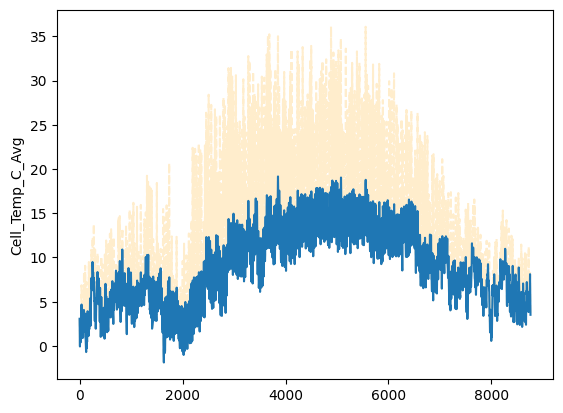

In [30]:
sns.lineplot(pv_model.combined_model["Cell_Temp_C_Avg"], alpha = 0.2, ls = "--", color = "orange")
sns.lineplot(pv_model.combined_model["T2m"])

2024-02-18 02:26:16,256 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-02-18 02:26:16,261 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Day_of_Year', ylabel='T2m'>

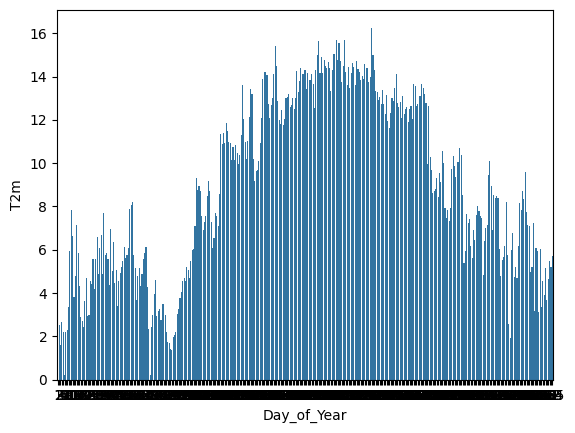

In [31]:
sns.barplot(pv_model.summary_grouped.daily.T2m)

<Axes: xlabel='Hour_of_Day', ylabel='PV_Gen_kWh_Total'>

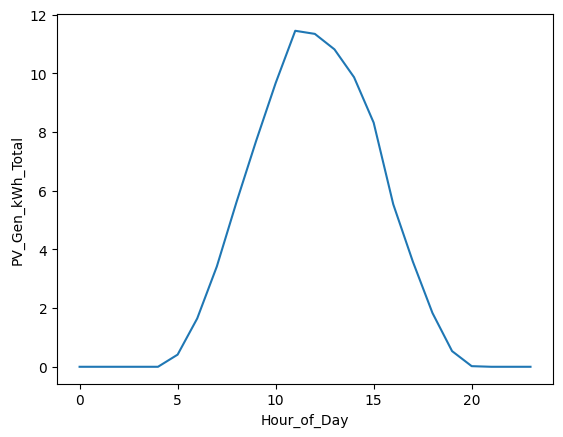

In [32]:
sns.lineplot(pv_model.combined_model.groupby("Hour_of_Day")["PV_Gen_kWh_Total"].mean())

In [33]:
pv_model.all_models["PV_Gen_kWh_Total"].sum()

33503.90540087376

In [34]:
pv_model.all_models.columns

Index(['E_Beam_kWm2_Array_1', 'E_Diffuse_kWm2_Array_1',
       'E_Ground_kWm2_Array_1', 'E_POA_kWm2_Array_1', 'Panel_POA_kWm2_Array_1',
       'ET_HRad_kWm2_Array_1', 'Cell_Temp_C_Array_1', 'PV_Gen_kWh_Array_1',
       'PV_Thermal_Loss_kWh_Array_1', 'IAM_Loss_kWm2_Array_1', 'AOI_Array_1',
       'Zenith_Angle_Array_1', 'E_Beam_kWm2_Array_2', 'E_Diffuse_kWm2_Array_2',
       'E_Ground_kWm2_Array_2', 'E_POA_kWm2_Array_2', 'Panel_POA_kWm2_Array_2',
       'ET_HRad_kWm2_Array_2', 'Cell_Temp_C_Array_2', 'PV_Gen_kWh_Array_2',
       'PV_Thermal_Loss_kWh_Array_2', 'IAM_Loss_kWm2_Array_2', 'AOI_Array_2',
       'Zenith_Angle_Array_2', 'E_Beam_kWm2_Array_3', 'E_Diffuse_kWm2_Array_3',
       'E_Ground_kWm2_Array_3', 'E_POA_kWm2_Array_3', 'Panel_POA_kWm2_Array_3',
       'ET_HRad_kWm2_Array_3', 'Cell_Temp_C_Array_3', 'PV_Gen_kWh_Array_3',
       'PV_Thermal_Loss_kWh_Array_3', 'IAM_Loss_kWm2_Array_3', 'AOI_Array_3',
       'Zenith_Angle_Array_3', 'E_Beam_kWm2_Array_4', 'E_Diffuse_kWm2_Array_4',
  

<Axes: ylabel='PV_Thermal_Loss_kWh_Total'>

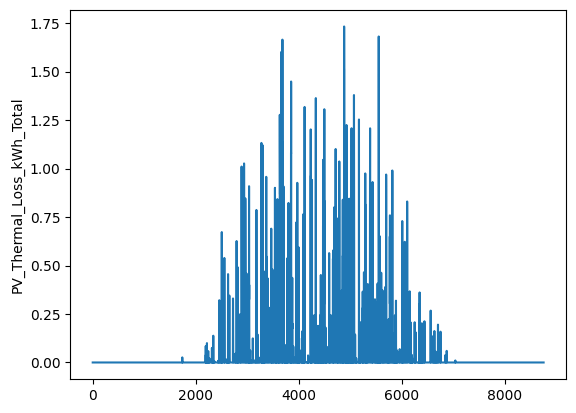

In [35]:
sns.lineplot(pv_model.all_models["PV_Thermal_Loss_kWh_Total"])

In [36]:
temp_losses = (pv_model.all_models["PV_Thermal_Loss_kWh_Total"].sum() / pv_model.all_models["PV_Gen_kWh_Total"].sum() * 100)

print(f"{round(temp_losses, 3)}% change to power due to temperature losses")

0.712% change to power due to temperature losses


In [37]:
pv_model.models[0]["model_result"]

,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year,T2m,Declination_Angle,Solar_Time,Hour_Angle,AOI,Zenith_Angle,...,E_Diffuse_kWm2,E_Ground_kWm2,E_POA_kWm2,Panel_POA_kWm2,IAM_Loss_kWm2,ET_HRad_kWm2,PV_Derated_Eff,Cell_Temp_C,PV_Gen_kWh,PV_Thermal_Loss_kWh
0,0,1,1,1,3.07,-23.011637,0.056353,-179.154706,134.868988,148.400772,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,3.07,0.0,0.0
1,1,1,1,1,2.63,-23.011637,1.056353,-164.154706,145.619004,146.256695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.63,0.0,0.0
2,2,1,1,1,2.18,-23.011637,2.056353,-149.154706,155.047781,140.930673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999999,2.18,0.0,0.0
3,3,1,1,1,1.73,-23.011637,3.056353,-134.154706,160.738141,133.633323,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.73,0.0,0.0
4,4,1,1,1,1.28,-23.011637,4.056353,-119.154706,159.201881,125.337294,...,0.0,0.0,0.0,0.0,0.0,0.0,0.999998,1.28,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,19,365,52,12,5.31,-23.085911,19.063871,105.958063,82.791716,117.783501,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995203,5.31,0.0,0.0
8756,20,365,52,12,4.86,-23.085911,20.063871,120.958063,91.941559,126.422350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995202,4.86,0.0,0.0
8757,21,365,52,12,4.41,-23.085911,21.063871,135.958063,102.050368,134.640378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995202,4.41,0.0,0.0
8758,22,365,52,12,3.97,-23.085911,22.063871,150.958063,112.785289,141.764593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.995201,3.97,0.0,0.0


In [38]:
pv_model.all_models

,E_Beam_kWm2_Array_1,E_Diffuse_kWm2_Array_1,E_Ground_kWm2_Array_1,E_POA_kWm2_Array_1,Panel_POA_kWm2_Array_1,ET_HRad_kWm2_Array_1,Cell_Temp_C_Array_1,PV_Gen_kWh_Array_1,PV_Thermal_Loss_kWh_Array_1,IAM_Loss_kWm2_Array_1,...,PV_Thermal_Loss_kWh_Total,IAM_Loss_kWm2_Total,Declination_Angle,Solar_Time,Hour_Angle,T2m,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.0,0.0,0.0,0.0,0.0,0.0,3.07,0.0,0.0,0.0,...,0.0,0.0,-23.011637,0.056353,-179.154706,3.07,0,1,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0,0.0,...,0.0,0.0,-23.011637,1.056353,-164.154706,2.63,1,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,2.18,0.0,0.0,0.0,...,0.0,0.0,-23.011637,2.056353,-149.154706,2.18,2,1,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.73,0.0,0.0,0.0,...,0.0,0.0,-23.011637,3.056353,-134.154706,1.73,3,1,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.28,0.0,0.0,0.0,...,0.0,0.0,-23.011637,4.056353,-119.154706,1.28,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,0.0,0.0,0.0,0.0,0.0,5.31,0.0,0.0,0.0,...,0.0,0.0,-23.085911,19.063871,105.958063,5.31,19,365,52,12
8756,0.0,0.0,0.0,0.0,0.0,0.0,4.86,0.0,0.0,0.0,...,0.0,0.0,-23.085911,20.063871,120.958063,4.86,20,365,52,12
8757,0.0,0.0,0.0,0.0,0.0,0.0,4.41,0.0,0.0,0.0,...,0.0,0.0,-23.085911,21.063871,135.958063,4.41,21,365,52,12
8758,0.0,0.0,0.0,0.0,0.0,0.0,3.97,0.0,0.0,0.0,...,0.0,0.0,-23.085911,22.063871,150.958063,3.97,22,365,52,12


In [39]:
pv_model.combined_model

,E_Beam_kWm2_Total,E_Diffuse_kWm2_Total,E_Ground_kWm2_Total,E_POA_kWm2_Total,Panel_POA_kWm2_Total,ET_HRad_kWm2_Total,Cell_Temp_C_Avg,PV_Gen_kWh_Total,PV_Thermal_Loss_kWh_Total,IAM_Loss_kWm2_Total,Declination_Angle,Solar_Time,Hour_Angle,T2m,Hour_of_Day,Day_of_Year,Week_of_Year,Month_of_Year
0,0.0,0.0,0.0,0.0,0.0,0.0,3.07,0.0,0.0,0.0,-23.011637,0.056353,-179.154706,3.07,0,1,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,2.63,0.0,0.0,0.0,-23.011637,1.056353,-164.154706,2.63,1,1,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,2.18,0.0,0.0,0.0,-23.011637,2.056353,-149.154706,2.18,2,1,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.73,0.0,0.0,0.0,-23.011637,3.056353,-134.154706,1.73,3,1,1,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.28,0.0,0.0,0.0,-23.011637,4.056353,-119.154706,1.28,4,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,0.0,0.0,0.0,0.0,0.0,5.31,0.0,0.0,0.0,-23.085911,19.063871,105.958063,5.31,19,365,52,12
8756,0.0,0.0,0.0,0.0,0.0,0.0,4.86,0.0,0.0,0.0,-23.085911,20.063871,120.958063,4.86,20,365,52,12
8757,0.0,0.0,0.0,0.0,0.0,0.0,4.41,0.0,0.0,0.0,-23.085911,21.063871,135.958063,4.41,21,365,52,12
8758,0.0,0.0,0.0,0.0,0.0,0.0,3.97,0.0,0.0,0.0,-23.085911,22.063871,150.958063,3.97,22,365,52,12


In [40]:
pv_model.summary

PV_Gen_kWh_Annual              33503.905
PV_Gen_kWh_Lifetime           785331.543
E_POA_kWm2_Annual               4781.110
Panel_POA_kWm2_Annual           4664.964
IAM_Loss_kWm2_Annual             116.146
PV_Thermal_Loss_kWh_Annual       238.624
E_Beam_kWm2_Annual              2108.155
E_Diffuse_kWm2_Annual           2587.621
E_Ground_kWm2_Annual              85.334
ET_HRad_kWm2_Annual            11352.896
Cell_Temp_C_Avg                   11.133
T2m_Avg                            8.899
dtype: float64

In [41]:
pv_model.summary_grouped.daily

,PV_Gen_kWh_Total,E_POA_kWm2_Total,Panel_POA_kWm2_Total,IAM_Loss_kWm2_Total,PV_Thermal_Loss_kWh_Total,E_Beam_kWm2_Total,E_Diffuse_kWm2_Total,E_Ground_kWm2_Total,ET_HRad_kWm2_Total,Cell_Temp_C_Avg,T2m
Day_of_Year,,,,,,,,,,,
1,3.923,0.541,0.541,0.000,0.0,0.000,0.530,0.011,6.910,1.509,1.417
2,13.250,1.894,1.828,0.066,0.0,0.716,1.148,0.030,6.977,2.834,2.522
3,12.640,1.811,1.744,0.068,0.0,0.740,1.043,0.028,7.058,1.898,1.600
4,21.395,3.119,2.951,0.168,0.0,1.688,1.388,0.042,7.146,3.181,2.676
5,25.551,3.781,3.524,0.256,0.0,2.317,1.415,0.049,7.240,2.818,2.215
...,...,...,...,...,...,...,...,...,...,...,...
361,30.035,4.489,4.163,0.327,0.0,2.973,1.464,0.053,6.688,4.377,3.663
362,24.460,3.615,3.390,0.225,0.0,2.055,1.512,0.048,6.722,5.236,4.654
363,12.105,1.743,1.678,0.066,0.0,0.613,1.102,0.028,6.761,5.786,5.499


In [42]:
pv_model.summary

PV_Gen_kWh_Annual              33503.905
PV_Gen_kWh_Lifetime           785331.543
E_POA_kWm2_Annual               4781.110
Panel_POA_kWm2_Annual           4664.964
IAM_Loss_kWm2_Annual             116.146
PV_Thermal_Loss_kWh_Annual       238.624
E_Beam_kWm2_Annual              2108.155
E_Diffuse_kWm2_Annual           2587.621
E_Ground_kWm2_Annual              85.334
ET_HRad_kWm2_Annual            11352.896
Cell_Temp_C_Avg                   11.133
T2m_Avg                            8.899
dtype: float64

In [43]:
pv_model.summary_grouped.monthly

,PV_Gen_kWh_Total,E_POA_kWm2_Total,Panel_POA_kWm2_Total,IAM_Loss_kWm2_Total,PV_Thermal_Loss_kWh_Total,E_Beam_kWm2_Total,E_Diffuse_kWm2_Total,E_Ground_kWm2_Total,ET_HRad_kWm2_Total,Cell_Temp_C_Avg,T2m
Month_of_Year,,,,,,,,,,,
1,773.257,112.921,106.680,6.241,0.000,62.819,48.552,1.550,275.167,4.555,3.964
2,1357.204,195.076,187.317,7.759,0.000,99.588,92.488,3.000,448.070,6.892,5.736
3,1604.645,225.245,221.552,3.693,0.026,60.474,160.760,4.011,858.421,4.469,3.241
4,4042.197,572.170,559.440,12.730,8.123,266.449,295.447,10.274,1238.404,10.021,6.774
5,5347.640,761.184,745.360,15.823,46.598,361.774,385.230,14.180,1620.270,15.252,11.035
6,4746.997,676.365,663.797,12.567,55.112,276.699,386.753,12.913,1716.717,17.109,13.222
7,4643.773,661.807,650.324,11.483,58.826,237.230,411.996,12.582,1696.427,18.115,14.425
8,4526.358,647.333,633.319,14.014,51.415,287.070,348.479,11.784,1404.894,17.493,13.902
9,2979.173,425.089,414.638,10.451,16.818,192.019,225.695,7.375,967.321,15.120,12.699


# ***MODEL ANALYSIS***